In [1]:
from os.path import isfile
import pandas as pd
import gc
import re
import numpy as np
import scipy.stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle
from sklearn.impute import KNNImputer

pd.set_option('float_format', '{:.4f}'.format)
%matplotlib inline

In [2]:
def_column_order = ['Price', 'Year', 'Mileage', 'City', 'State', 'Make', 'Model']
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


def get_column_order(current_order: list):
    return [x for x in def_column_order if x in current_order]


def proceed_cat_str(in_cat: pd.Series, trim=-1):
    res_cat = in_cat.map(
        lambda x: "".join(re.findall("[a-zA-Z0-9]+", x)) if type(x) is str else np.NaN
    )

    res_cat = res_cat.map(
        lambda x: str.upper(x) if type(x) is str else np.NaN
    )

    if trim != -1:
        res_cat = res_cat.str[:trim]

    return res_cat


def concat_cat(src_df: pd.DataFrame, name: str):
    res_cat = pd.Series(dtype=str)
    res_cat.name = name

    for col in src_df:
        if res_cat.shape[0] == 0:
            res_cat = src_df[col].astype(str)
        else:
            res_cat = res_cat + src_df[col].astype(str)

    return res_cat

# **Анализ данных.**

Взглянем издалека на числовые данные.

In [3]:
src_df = pd.read_csv('./data/true_car_listings_prepeared.csv')
src_df.drop_duplicates(inplace=True)

numeric = src_df.select_dtypes(include=numeric_types)

print(numeric.describe())

            Price        Year      Mileage
count 852105.0000 852105.0000  731162.0000
mean   20121.2714   2013.2891   52519.6486
std    14123.2041      3.4150   42036.4440
min        0.0000   1997.0000       5.0000
25%    11997.0000   2012.0000   23837.0000
50%    17900.0000   2014.0000   40265.0000
75%    26398.0000   2016.0000   72228.0000
max   499500.0000   2018.0000 2856196.0000


Выбросы точно присутствуют. Попробую визуально.

![title](img/06.png)

Что и требовалось показать, что называется.

In [4]:
print(numeric.describe(percentiles=np.arange(start=0.0, stop=1.00, step=0.05)))

            Price        Year      Mileage
count 852105.0000 852105.0000  731162.0000
mean   20121.2714   2013.2891   52519.6486
std    14123.2041      3.4150   42036.4440
min        0.0000   1997.0000       5.0000
0%         0.0000   1997.0000       5.0000
5%         0.0000   2006.0000    6577.0000
10%     6550.0000   2008.0000   12126.0000
15%     8995.0000   2010.0000   16514.0000
20%    10850.0000   2011.0000   20251.0000
25%    11997.0000   2012.0000   23837.0000
30%    13277.0000   2013.0000   27300.0000
35%    14455.0000   2013.0000   30543.0000
40%    15500.0000   2014.0000   33685.0000
45%    16733.0000   2014.0000   36745.0000
50%    17900.0000   2014.0000   40265.0000
55%    18990.0000   2014.0000   43982.0000
60%    20295.0000   2015.0000   48539.0000
65%    21999.0000   2015.0000   54845.0000
70%    23998.0000   2015.0000   62988.0000
75%    26398.0000   2016.0000   72228.0000
80%    28900.0000   2016.0000   82443.0000
85%    31843.0000   2016.0000   94358.0000
90%    3559

Интересно. А сколько у нас записей до, скажем, 2000-го года?

In [5]:
print(numeric.where(src_df['Year'] <= 2000).describe())

            Price      Year     Mileage
count   4557.0000 4557.0000   3871.0000
mean    6905.0266 1998.9928 144933.2304
std    10903.3134    1.0571  69101.1093
min        0.0000 1997.0000    111.0000
25%     2995.0000 1998.0000  98420.5000
50%     4680.0000 1999.0000 140723.0000
75%     7500.0000 2000.0000 183427.0000
max   224995.0000 2000.0000 999999.0000


2010-го?

In [6]:
print(numeric.where(src_df['Year'] <= 2010).describe())

            Price        Year      Mileage
count 143274.0000 143274.0000  122931.0000
mean   10920.9394   2006.9331  112431.4654
std     9615.6580      2.7149   47737.7481
min        0.0000   1997.0000       5.0000
25%     5999.2500   2006.0000   82909.5000
50%     9299.0000   2007.0000  107684.0000
75%    13980.0000   2009.0000  136679.5000
max   490000.0000   2010.0000 2856196.0000


Пока только ясно, что древних машин в наборе мало. Попробую оценить выбросы по пробегу.

In [7]:
print(numeric.where(src_df['Mileage'] >= 1000000).describe())

           Price      Year      Mileage
count    12.0000   12.0000      12.0000
mean   8907.3333 2006.5833 1680738.5000
std    9008.4631    3.1176  555704.0516
min       0.0000 2002.0000 1000000.0000
25%    3899.7500 2005.0000 1392331.0000
50%    5490.5000 2006.0000 1511505.5000
75%   14013.2500 2008.0000 1895310.2500
max   31500.0000 2013.0000 2856196.0000


In [8]:
print(numeric.where(src_df['Mileage'] >= 500000).describe())

           Price      Year      Mileage
count    47.0000   47.0000      47.0000
mean  15533.0851 2007.2766 1066293.6596
std   18357.8012    4.8486  476885.9661
min       0.0000 1997.0000  527411.0000
25%    3449.5000 2004.5000  777427.0000
50%    5999.0000 2006.0000  999999.0000
75%   25835.0000 2011.0000  999999.5000
max   99999.0000 2017.0000 2856196.0000


In [9]:
print(numeric.where(src_df['Mileage'] >= 200000).describe())

           Price      Year      Mileage
count  4838.0000 4838.0000    4838.0000
mean   7299.2433 2004.5043  241234.6561
std    6862.7746    3.6458  100097.1164
min       0.0000 1997.0000  200000.0000
25%    3498.2500 2002.0000  209619.2500
50%    5500.0000 2004.0000  223245.5000
75%    9599.7500 2007.0000  246694.0000
max   99999.0000 2017.0000 2856196.0000


**Дилема.** Всё было бы понятно, если бы не 100+К значений NaN пробега. Нужно проанализировать какие авто попали в пробег более 200К.

А сколько моделей есть в наборе до 2004 и нет в после?

In [10]:
src_df['Model'] = proceed_cat_str(src_df['Model'])

before2004 = src_df.where(src_df['Year'] <= 2004)['Model'].value_counts().keys()
after2004 = src_df.where(src_df['Year'] > 2004)['Model'].value_counts().keys()

inter = np.setdiff1d(before2004, after2004)
print("There is {} unique models before 2004.".format(len(inter)))

There is 269 unique models before 2004.


И сколько записей входит в это условие?

In [11]:
old_model_df = src_df.query('Model in @inter')
print("There is {} rows to delete.".format(old_model_df.shape[0]))

There is 2765 rows to delete.


Итак, попробуем удалить записи, где: <br>
1. Уникальные модели до 2004-го года.
2. До 2004-го года выпуска.
3. Пробег более 200К

In [12]:
src_row_c = src_df.shape[0]

src_df = src_df.loc[
        (~src_df['Model'].isin(old_model_df['Model'])) &
        (src_df['Year'] > 2004) &
        (src_df['Mileage'] < 200000)
]

processed_row_c = src_df.shape[0]

print("{} rows was deleted.".format(src_row_c - processed_row_c))

144512 rows was deleted.


Интересно, а сколько порченых записей осталось.

In [13]:
print(src_df.isna().sum())

Price          0
Year           0
Mileage        0
City           0
State          0
Vin            0
Make           0
Model      64071
dtype: int64


Вот это номер - ушли все порченные значения пробега!

**Рассуждение.**

На первый взгляд, то к чему я пришел выглядит не обоснованным. Шутка ли, 140К записей убрать? <br>
Но на самом деле, всё логично. 
1. США автомобильная страна. Автомобили стоят там дешево. Для штатов автомобиль старше 15 лет - металлолом. Или коллекционная модель. Поэтому при заполнении базы для таких авто могли просто пробег не указывать - зачем?
2. Автомобили с большим пробегом вполне могут стоить денег - грузовики и коммерческий ресурсный транспорт. И вот вопрос - а он нам в модели нужен? Мы же явно работаем с легковыми автомобилями.
3. Рассуждение касательно коллекционных автомобилей то-же, что для коммерческих.

In [14]:
print(src_df.loc[src_df['Price'] == 0].shape[0])

44210


Как видно, нам ещё есть что предсказывать.

![title](img/09.png)

Намного более приятная картина.

Хотя явно видно, что за какую-то модель золотишка отсыпают вне зависимости от пробега. Уж не NaN ли это? Узнаем истину вместе, как говорится.

# **Категориальные данные.**

В общем случае есть два варианта, закодировать числом или унитарным кодом. Я экспериментировал с унитарным кодом - мне очень не понравилось. Если категорий мало, до десятка, то еще ничего. 
Но при большом количестве категорий унитарный код создает слишком большую матрицу, что приводит к катострофическому расходу памяти. Поэтому я буду использовать Label encodng. <br>
VIN изначально уникальный идентификатор, никакой пользы он не принесет.

In [15]:
src_df.drop('Vin', inplace=True, axis=1)

src_df['Make'] = proceed_cat_str(src_df['Make'])
src_df['City'] = proceed_cat_str(src_df['City'])
src_df['State'] = proceed_cat_str(src_df['State'])

temp_df = src_df[['Model', 'Make', 'City', 'State']].astype('category').apply(lambda x: x.cat.codes)
temp_df = temp_df.where(~src_df.isna(), src_df)

src_df['Model'] = temp_df['Model'].astype('float')
src_df['Make'] = temp_df['Make']
src_df['City'] = temp_df['City']
src_df['State'] = temp_df['State']

del temp_df
gc.collect()

print(src_df.head)

<bound method NDFrame.head of         Price  Year    Mileage  City  State  Make     Model
0        8995  2014 35725.0000   626     43     0 1045.0000
2        8995  2013 48851.0000   626     43     0 1045.0000
3       10999  2014 39922.0000  2334      5     0 1044.0000
6       14490  2014 34032.0000   835     34     0 2030.0000
7       13995  2013 32384.0000  2280     44     0 2026.0000
...       ...   ...        ...   ...    ...   ...       ...
852117  63215  2017     9.0000   477      4    53 1756.0000
852118  72260  2017  3201.0000   636     31    53 2216.0000
852119  55999  2016 28941.0000   717      5    53 2210.0000
852120  60240  2017  3005.0000  1875      4    53 2069.0000
852121  76995  2017  2502.0000  1484     34    53 2217.0000

[707593 rows x 7 columns]>


In [16]:
print(src_df.isna().sum())

Price          0
Year           0
Mileage        0
City           0
State          0
Make           0
Model      64071
dtype: int64


![title](img/10.png)

![title](img/11.png)

На данный момент никаких аномалий я не наблюдаю.

# **Импутация данных.**

Собственно, нужно импутировать только модель.

Поскольку это явно задача классификации, попробую KNN.

In [17]:
#imputer = KNNImputer(n_neighbors=3)

#src_df_imputed = pd.DataFrame(imputer.fit_transform(src_df), columns=src_df.columns)

#src_df_imputed.to_pickle(path="./data/src_df_model_imputed.pkl", compression='zip')

In [18]:
src_df_imputed = pd.read_pickle(filepath_or_buffer="./data/src_df_model_imputed.pkl", compression='zip')
src_df_imputed.index = src_df.index
src_df_imputed = src_df_imputed.astype('int64')

In [19]:
idx = src_df.loc[src_df['Model'].isna()].index

print(src_df.loc[src_df.index.isin(idx)])
print(src_df_imputed.loc[src_df_imputed.index.isin(idx)])

        Price  Year    Mileage  City  State  Make  Model
9        9995  2013 63887.0000   626     43     0    NaN
12       7750  2009 91980.0000  1857     43     0    NaN
31      14999  2015 28326.0000  1312      9     0    NaN
41      14994  2014 22266.0000  1918      9     0    NaN
45      15965  2015 30091.0000  2216     34     0    NaN
...       ...   ...        ...   ...    ...   ...    ...
852105  59970  2017  2773.0000  1550     14    53    NaN
852108      0  2017     8.0000  1875      4    53    NaN
852113  63995  2017  4304.0000  1484     34    53    NaN
852114  53855  2017  7530.0000  1248     10    53    NaN
852116  54995  2017  2474.0000   154     38    53    NaN

[64071 rows x 7 columns]
        Price  Year  Mileage  City  State  Make  Model
9        9995  2013    63887   626     43     0   1120
12       7750  2009    91980  1857     43     0   1040
31      14999  2015    28326  1312      9     0    355
41      14994  2014    22266  1918      9     0   1106
45      15965  

Ну, ничего не поломалось на первый взгляд.

# **Обучение модели и конструирование параметров.**

In [20]:
to_predict_ds = src_df_imputed.loc[src_df_imputed['Price'] == 0]
work_ds = src_df_imputed.loc[src_df_imputed['Price'] != 0]

print(to_predict_ds.shape)
print(work_ds.shape)

(44210, 7)
(663383, 7)


In [21]:
del numeric
del src_df
del src_df_imputed

gc.collect()

0

In [22]:
xgb_model_01 = xgb.XGBRegressor()

X = work_ds[['Year', 'Make', 'State', 'City', 'Mileage', 'Model']]
y = work_ds['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)

if isfile("./data/models/iter_01_model.pkl"):
    with open("./data/models/iter_01_model.pkl", "rb") as m_file:
        xgb_model_01 = pickle.load(m_file)
else:
    xgb_model_01 = xgb.train(params={'objective': 'reg:squarederror'},
                             dtrain=dmatrix_train,
                             evals=[(dmatrix_train, "train"), (dmatrix_test, "validation")],
                             num_boost_round=10000,
                             verbose_eval=20,
                             early_stopping_rounds=25
                             )
    
    with open("./data/models/iter_01_model.pkl", "wb") as m_file:
        pickle.dump(xgb_model_01, m_file)

In [23]:
xgb_preds = xgb_model_01.predict(dmatrix_test)
r2 = r2_score(y_test, xgb_preds)
print("Model trained with R2 = {:.4f}.".format(r2))

Model trained with R2 = 0.8660.


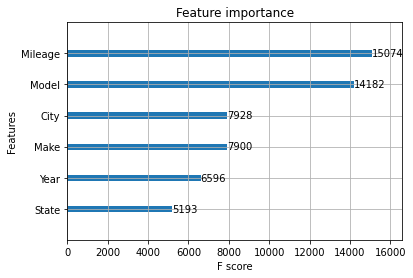

In [24]:
xgb.plot_importance(xgb_model_01)
plt.show()

Можно попробовать создать два полиноминальных признака год-производитель-модель и штат-город.

In [25]:
work_ds['YMM'] = work_ds['Year'] * work_ds['Make'] * work_ds['Model']
work_ds['SC'] = work_ds['State'] * work_ds['City']


In [26]:
print(work_ds.head)

<bound method NDFrame.head of         Price  Year  Mileage  City  State  Make  Model        YMM      SC
0        8995  2014    35725   626     43     0   1045          0   26918
2        8995  2013    48851   626     43     0   1045          0   26918
3       10999  2014    39922  2334      5     0   1044          0   11670
6       14490  2014    34032   835     34     0   2030          0   28390
7       13995  2013    32384  2280     44     0   2026          0  100320
...       ...   ...      ...   ...    ...   ...    ...        ...     ...
852117  63215  2017        9   477      4    53   1756  187718156    1908
852118  72260  2017     3201   636     31    53   2216  236892616   19716
852119  55999  2016    28941   717      5    53   2210  236134080    3585
852120  60240  2017     3005  1875      4    53   2069  221178169    7500
852121  76995  2017     2502  1484     34    53   2217  236999517   50456

[663383 rows x 9 columns]>


In [27]:
xgb_model_02 = xgb.XGBRegressor()

X = work_ds[['Year', 'Make', 'State', 'City', 'Mileage', 'Model', 'YMM', 'SC']]
y = work_ds['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)

if isfile("./data/models/iter_02_model.pkl"):
    with open("./data/models/iter_02_model.pkl", "rb") as m_file:
        xgb_model_02 = pickle.load(m_file)
else:
    xgb_model_02 = xgb.train(params={'objective': 'reg:squarederror'},
                             dtrain=dmatrix_train,
                             evals=[(dmatrix_train, "train"), (dmatrix_test, "validation")],
                             num_boost_round=10000,
                             verbose_eval=20,
                             early_stopping_rounds=25
                             )
    
    with open("./data/models/iter_02_model.pkl", "wb") as m_file:
        pickle.dump(xgb_model_02, m_file)

In [28]:
xgb_preds = xgb_model_02.predict(dmatrix_test)
r2 = r2_score(y_test, xgb_preds)
print("Model trained with R2 = {:.4f}.".format(r2))

Model trained with R2 = 0.8619.


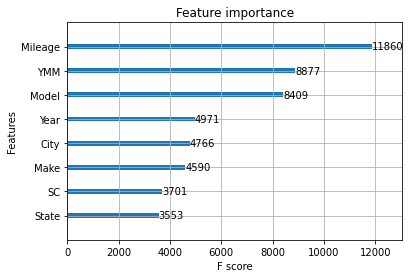

In [29]:
xgb.plot_importance(xgb_model_02)
plt.show()

Ну особой разницы никакой. А если убрать некоторые столбцы?

In [30]:
xgb_model_03 = xgb.XGBRegressor()

X = work_ds[['Year', 'Mileage', 'YMM', 'SC']]
y = work_ds['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)

if isfile("./data/models/iter_03_model.pkl"):
    with open("./data/models/iter_03_model.pkl", "rb") as m_file:
        xgb_model_03 = pickle.load(m_file)
else:
    xgb_model_03 = xgb.train(params={'objective': 'reg:squarederror'},
                             dtrain=dmatrix_train,
                             evals=[(dmatrix_train, "train"), (dmatrix_test, "validation")],
                             num_boost_round=10000,
                             verbose_eval=20,
                             early_stopping_rounds=25
                             )
    
    with open("./data/models/iter_03_model.pkl", "wb") as m_file:
        pickle.dump(xgb_model_03, m_file)

In [31]:
xgb_preds = xgb_model_03.predict(dmatrix_test)
r2 = r2_score(y_test, xgb_preds)
print("Model trained with R2 = {:.4f}.".format(r2))

Model trained with R2 = 0.7679.


Нда, не получилось.

Попробую нормализовать данные.

In [32]:
X = work_ds[['Year', 'Make', 'State', 'City', 'Mileage', 'Model']]
y = work_ds['Price']

In [33]:
X = X.apply(zscore)
y = y.map(np.log)

In [34]:
xgb_model_04 = xgb.XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)

if isfile("./data/models/iter_04_model.pkl"):
    with open("./data/models/iter_04_model.pkl", "rb") as m_file:
        xgb_model_04 = pickle.load(m_file)
else:
    xgb_model_04 = xgb.train(params={'objective': 'reg:squarederror'},
                             dtrain=dmatrix_train,
                             evals=[(dmatrix_train, "train"), (dmatrix_test, "validation")],
                             num_boost_round=10000,
                             verbose_eval=20,
                             early_stopping_rounds=25
                             )
    
    with open("./data/models/iter_04_model.pkl", "wb") as m_file:
        pickle.dump(xgb_model_04, m_file)

In [35]:
xgb_preds = xgb_model_04.predict(dmatrix_test)
r2 = r2_score(y_test, xgb_preds)
print("Model trained with R2 = {:.4f}.".format(r2))

Model trained with R2 = 0.8949.


О! Подросла точность. С этой моделью и буду работать.

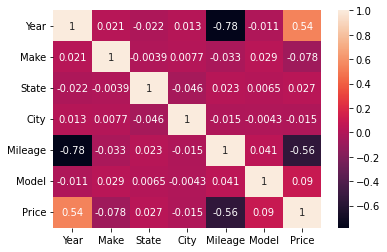

In [36]:
temp_df = X.join(y)
sns.heatmap(temp_df.corr(), annot=True)
plt.show()

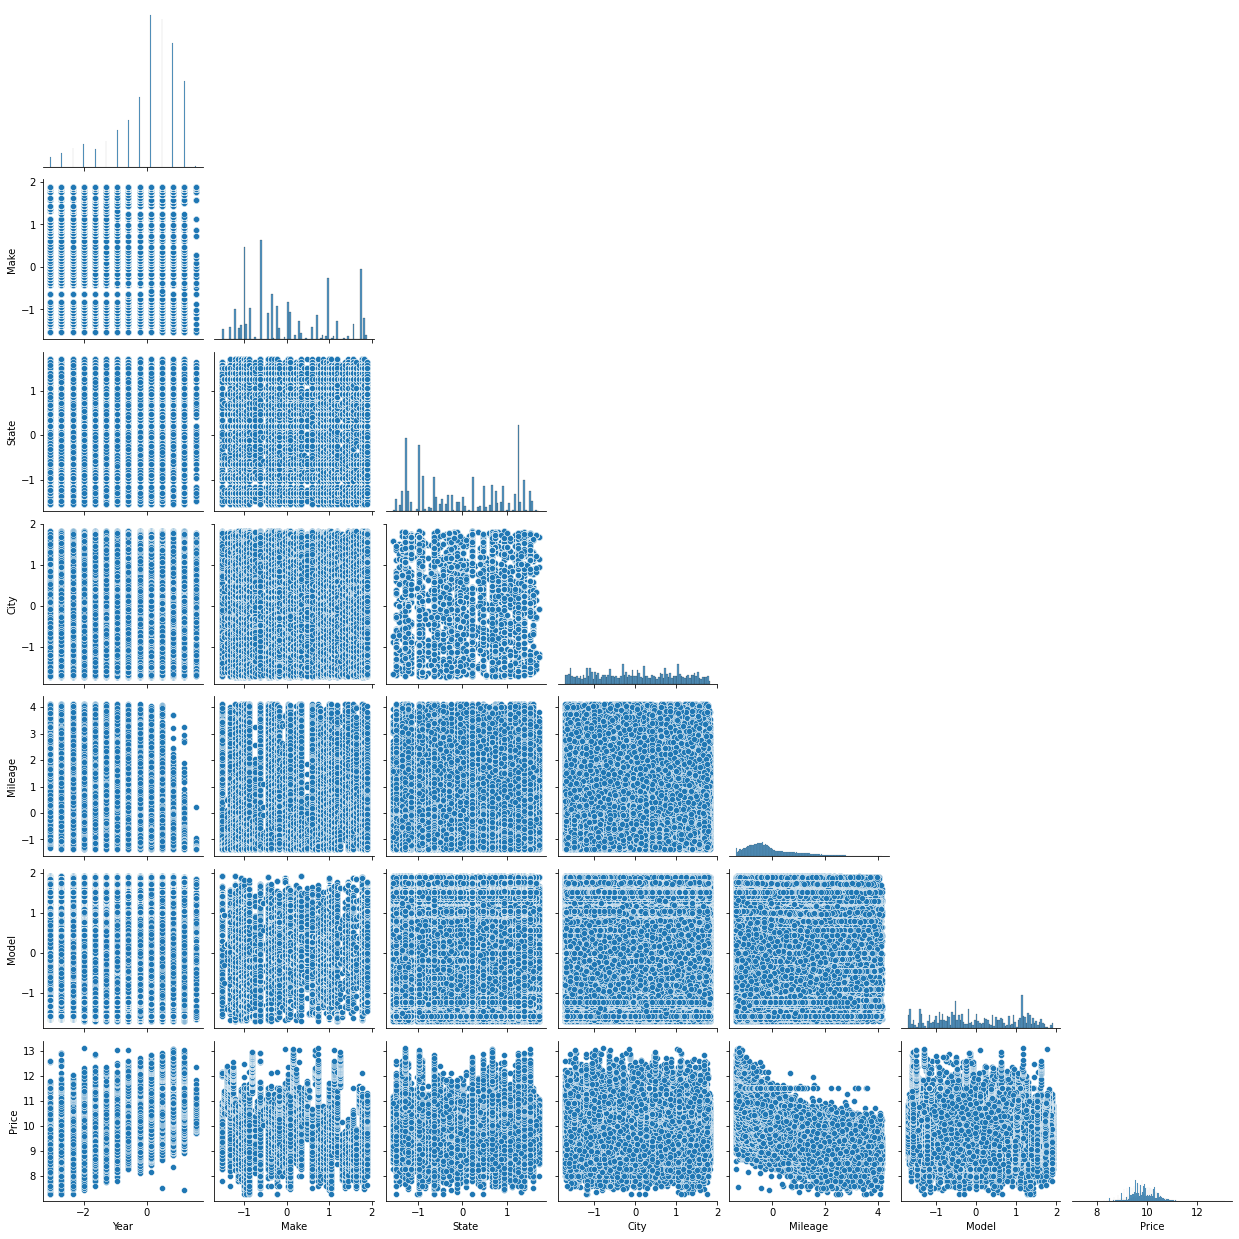

In [37]:
sns.pairplot(data=temp_df, corner=True)
plt.show()

In [38]:
X = to_predict_ds[['Year', 'Make', 'State', 'City', 'Mileage', 'Model']]
X = X.apply(zscore)
print(X.head)

<bound method NDFrame.head of           Year    Make   State    City  Mileage   Model
49      0.1328 -1.5298 -0.9638 -1.1321  -0.8938 -0.0737
74      0.1328 -1.5298 -1.2900  1.2657  -0.7791  1.4654
79      0.4836 -1.5298 -1.2900  0.3027  -0.8466 -0.0737
91     -0.5687 -1.5298 -0.9638 -0.3141   0.8607  0.3228
127     0.4836 -1.5298  1.5158  1.3604  -0.4823 -0.0737
...        ...     ...     ...     ...      ...     ...
852015  0.8344  1.8983  1.2548  0.5853  -0.1629  1.7538
852044  0.8344  1.8983 -0.7680 -1.1203  -0.9457  1.7538
852060  0.8344  1.8983 -0.6375  0.5734  -0.8506  1.7538
852095  1.1852  1.8983  0.4065 -1.0818  -1.2617  1.5328
852108  1.1852  1.8983 -1.2900  1.0542  -1.3523  0.5564

[44210 rows x 6 columns]>


In [39]:
print(to_predict_ds.head)

dmatrix_predict = xgb.DMatrix(X)

<bound method NDFrame.head of         Price  Year  Mileage  City  State  Make  Model
49          0  2014    16848   397      9     0   1044
74          0  2014    21064  2018      4     0   2026
79          0  2015    18583  1367      4     0   1044
91          0  2012    81301   950      9     0   1297
127         0  2015    31968  2082     47     0   1044
...       ...   ...      ...   ...    ...   ...    ...
852015      0  2016    43699  1558     43    53   2210
852044      0  2016    14942   405     12    53   2210
852060      0  2016    18435  1550     14    53   2210
852095      0  2017     3335   431     30    53   2069
852108      0  2017        8  1875      4    53   1446

[44210 rows x 7 columns]>


In [40]:
xgb_preds = xgb_model_04.predict(dmatrix_predict)

In [41]:
xgb_preds = [int(np.e ** x) for x in xgb_preds]

In [42]:
to_predict_ds['Price'] = xgb_preds

In [43]:
print(to_predict_ds.head)

<bound method NDFrame.head of         Price  Year  Mileage  City  State  Make  Model
49      16421  2014    16848   397      9     0   1044
74      18715  2014    21064  2018      4     0   2026
79      20508  2015    18583  1367      4     0   1044
91      16568  2012    81301   950      9     0   1297
127     20231  2015    31968  2082     47     0   1044
...       ...   ...      ...   ...    ...   ...    ...
852015  47636  2016    43699  1558     43    53   2210
852044  50804  2016    14942   405     12    53   2210
852060  47723  2016    18435  1550     14    53   2210
852095  49434  2017     3335   431     30    53   2069
852108  43282  2017        8  1875      4    53   1446

[44210 rows x 7 columns]>


# **Заключение.**

ML это о подумать. Хорошенько подумать, прежде чем что-то делать. Поскольку любой шаг это память и вычисления. **Много памяти и много вычислений.** <br>
Я пришел к тому, что нужно иметь некий очень малый датасет для отработки программной модели. Очень обидно час ждать пока KNNImputer что-то посчитает и получить ошибку на принте до сохранения. <br>
В ML не получается (у меня) заниматься "быстрокодингом". Нужно всё проверять и перепроверять. Индексы, типы, порядок выборки столбцов и вобще всё. Поскольку любая семантическая ошибка или непонимание делаемого приводит к неправильной работе модели. И выясняется это уже где-то ближе к концу, когда потрачено много ресурсов. <br> 
Всё что можно, нужно сохранять. Обучил модель - сохрани. Получил датасет - сохрани. <br><br>
Качество входных данных это очень большая часть правильной работы модели. <br>
Не буду утверждать, но исходя из проделанной работы, плохие данные только с некоторой натяжкой можно как-то восстановить. И нет никакой гарантии, что это сделанно правильно. <br>
Понимание предметной области тоже важно. Просто понимая что такое VIN, можно было-бы намайнить очень много дополнительной информации о каждом авто.